Reading csv file...
Getting Traning Data...
Getting Testing Data...
Reading stop files
Smoothing value  0.1
Building Model with smoothing =  0.1
Generate Vocabulary
Returning list without removing stop words
Complete Vocabulary can be found in vocabulary.txt, vocabulary length =  85305
Getting number of classes
Classes:  ['story', 'ask_hn', 'show_hn', 'poll']
Getting vocabulary of each class and frequency of words
Returning list without removing stop words
Returning list without removing stop words
Returning list without removing stop words
Returning list without removing stop words
Generating model-2018.txt....
Complete file  model-2018.txt
Building  dict
Created dict 
Generating baseline-result.txt....
Completed baseline-result.txt
Calculating Smoothing performance
Smoothing value  0.2
Building Model with smoothing =  0.2
Generate Vocabulary
Returning list without removing stop words
Complete Vocabulary can be found in vocabulary.txt, vocabulary length =  85305
Getting number of clas

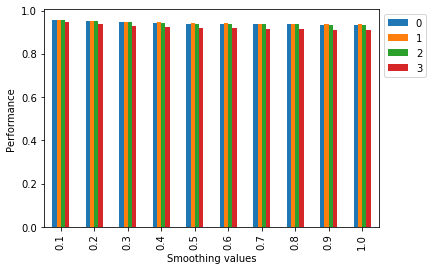

In [2]:
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
from sklearn import metrics
import io
import string
import collections
import math
import time


class trainingData:
    NUM_CLASSES = 0
    VOCAB_LENGTH = 0
    CLASS_TYPES = []
    CLASS_VOCAB_LEN = []
    CLASS_PROBABILITY = []
    ORIGINAL_CLASSIFICATION = []
    STOP_WORDS_VOCABULARY = []
    PREDICTED_CLASSIFICATION = []
    DICT_SCORE = {"ACCURACY": [], "PRECISION": [], "RECALL":
        [], "F1_SCORE": []}



def getVocabulary(trainData, stop_words, word_len_filter,freq_word_filter):
    # Change all words to lowercase
    newLowerTitle = trainData["Title"].str.lower()
    words = []
    tknzr = TweetTokenizer()

    # Get Tokens
    for index, row in newLowerTitle.iteritems():
        words.append(tknzr.tokenize(row))
    lemmatizer = nltk.stem.WordNetLemmatizer()
    vocabulary = []

    # Lemmatize  words
    for word in words:
        for w in word:
            vocabulary.append(lemmatizer.lemmatize(w))
    # Remove Punctuation and special Characters
    removePunVocabulary = [''.join(c for c in s if c not in string.punctuation) for s in vocabulary]
    removePunVocabulary = [s for s in removePunVocabulary if s]
    # newVocabulary = [re.sub('[^A-Za-z0-9]+', '', s) for s in removePunVocabulary]
    removePunVocabulary.sort()
    removePunVocabulary = list(filter(None, removePunVocabulary))

    # Word Length filtering
    if word_len_filter:
        print('Word length filtering enabled')
        removePunVocabulary = [word for word in removePunVocabulary if 2 < len(word) < 9]

    # Remove stop words
    if stop_words:
        print("Stop words enabled")
        removed_stop_words_list = [word for word in removePunVocabulary if
                                   word not in trainingData.STOP_WORDS_VOCABULARY]
        return removed_stop_words_list
    else:
        print("Returning list without removing stop words")
        return removePunVocabulary


def buildModel(trainData, smooth, stop_words, word_len_filt, freq_words_filter):
    print("Building Model with smoothing = ", smooth)
    # Generate Vocabulary
    print("Generate Vocabulary")
    vocabulary = getVocabulary(trainData, stop_words, word_len_filt, freq_words_filter)
    vocabulary = list(filter(None, vocabulary))
    counter = collections.Counter(vocabulary)
    vocabulary = list(counter.keys())
    vocabulary = list(filter(None, vocabulary))
    
    '''
     # Filtering words by freq
    if freq_words_filter:
        freq = 1
        print('Removing words with Freq', freq)
        fdist = FreqDist()
        for word in vocabulary:
            fdist[word] += 1
        # For testing
        words_freq_1 = list(filter(lambda x : x[1] == 1,fdist.items()))
        print(words_freq_1)
        print('Created Freq Dist')
        print(fdist.items())
        filterd_vocabulary = dict(filter(lambda x: x[1] > freq, fdist.items()))
        vocabulary = [k for k in filterd_vocabulary]
        print(vocabulary)
    '''


    # final sorted vocabulary
    # vocabulary.sort()
    with io.open('vocabulary.txt', "w", encoding="utf-8") as f:
        for item in vocabulary:
            f.write("%s\n" % item)
    # Get length of vocabulary
    vocabularyLen = len(vocabulary)
    trainingData.VOCAB_LENGTH = vocabularyLen
    print("Complete Vocabulary can be found in vocabulary.txt, vocabulary length = ", vocabularyLen)

    # Get number of post types
    print("Getting number of classes")
    post_type = trainData["Post Type"]
    count_type = collections.Counter(post_type)
    types = list(count_type.keys())
    trainingData.CLASS_TYPES = types
    trainingData.NUM_CLASSES = len(types)
    print("Classes: ", types)
    classProbability(post_type, types)

    counter = 0
    # Get vocabulary set for each post type
    print("Getting vocabulary of each class and frequency of words")
    for item in types:
        sdata = "Class" + str(counter) + "Data"
        globals()[sdata] = trainData[trainData["Post Type"] == item]
        svocab = "Class" + str(counter) + "Vocab"
        globals()[svocab] = getVocabulary(globals()[sdata], stop_words, word_len_filt,freq_words_filter)
        globals()[svocab] = list(filter(None, globals()[svocab]))
        # length of vocabulary for eah post type
        count_type = collections.Counter(globals()[svocab])
        sLen = "Class" + str(counter) + "Len"
        globals()[sLen] = len(list(count_type.keys()))
        trainingData.CLASS_VOCAB_LEN.append(globals()[sLen])
        # frequency of each word in each post type
        sFreq = "Class" + str(counter) + "Frequency"
        globals()[sFreq] = nltk.FreqDist(globals()[svocab])
        counter = counter + 1



    if stop_words:
        print("Generating stopword-model.txt")
        file = io.open("stopword-model.txt", "w", encoding="utf-8")
    elif word_len_filt:
        print('Generating wordlength-model.txt')
        file = io.open("wordlength-model.txt", "w", encoding="utf-8")
    else:
        print("Generating model-2018.txt....")
        file = io.open("model-2018.txt", "w", encoding="utf-8")

    line = 0
    for word in vocabulary:
        s = ''
        line += 1
        # print(line)
        s += str(line) + "  "
        s += word + "  "

        for i in range(trainingData.NUM_CLASSES):
            if globals()["Class" + str(i) + "Frequency"].__contains__(word):
                c = globals()["Class" + str(i) + "Frequency"].get(word)
            else:
                c = 0
            s += str(c) + "  "
            itemLen = trainingData.CLASS_VOCAB_LEN[i]
            probability = (c + smooth) / (itemLen + trainingData.VOCAB_LENGTH * smooth)
            s += format(probability, '.12f') + "  "
        s += '\r'
        file.write(s)
    print("Complete file ", file.name)
    file.close()


def classProbability(trainClasses, post_types):
    classFrequency = nltk.FreqDist(trainClasses)
    totalPosts = len(trainClasses)
    for item in post_types:
        frequency = classFrequency.get(item)
        class_prob = frequency / totalPosts
        trainingData.CLASS_PROBABILITY.append(class_prob)


def buildDictonary(file):
    dictionary = {}
    model_2018 = file.readlines()
    model_2018 = [x.strip() for x in model_2018]
    print("Building  dict")

    for row in model_2018:
        row_split_list = row.split('  ')
        dictionary[row_split_list[1]] = row_split_list[2:]

    print("Created dict ")
    return dictionary


def sum_cond_prob(tokenList, dictionary, smooth, classNum):
    sum = 0
    # print("Calculate conditional probabiliy of words given Class", classNum)
    for token in tokenList:
        if token in dictionary:
            cond_prob = dictionary.get(token)
            index = classNum + classNum + 1
            prob = float(cond_prob[index])
            sum = sum + math.log10(prob)
        else:
            prob = smooth / (trainingData.CLASS_VOCAB_LEN[classNum] + trainingData.VOCAB_LENGTH * smooth)
            sum += math.log10(prob)
    return sum


def classify(tokenizeList, dictionary, smooth):
    classifed_type = ''
    scores = []
    for i in range(trainingData.NUM_CLASSES):
        probability = math.log10(trainingData.CLASS_PROBABILITY[i]) + sum_cond_prob(tokenizeList, dictionary, smooth, i)
        scores.append(probability)
    max_prob = max(scores)
    for i in range(trainingData.NUM_CLASSES):
        if max_prob == scores[i]:
            # print("max_prob: ",max_prob)
            classified_type = trainingData.CLASS_TYPES[i]
    d = dict()
    d['classType'] = classified_type
    d['scores'] = scores
    return d


# Tokenize tile, Remove puncuations and lemmentize for each title
def tokenize_title(title):
    # print("Tokenizing test data title")
    tweetTokenizer = TweetTokenizer()
    tokenList = tweetTokenizer.tokenize(title)
    lemmentizeList = []
    lemmatizer = nltk.stem.WordNetLemmatizer()

    for word in tokenList:
        lemmentizeList.append(lemmatizer.lemmatize(word))

    removePunTokens = [''.join(c for c in s if c not in string.punctuation) for s in lemmentizeList]
    removePunTokens = [s for s in removePunTokens if s]
    # print(removePunTokens)
    return removePunTokens


def buildClassifier(testData, smoothing_value, stop_words, word_len_filter):
    if stop_words:
        file = io.open("stopword-model.txt", encoding="utf-8")
        dictionary = buildDictonary(file)
        print("Generating stopword-result.txt...")
        file = io.open("stopword-result.txt", "w", encoding="utf-8")
    elif word_len_filter:
        file = io.open("wordlength-model.txt", encoding="utf-8")
        dictionary = buildDictonary(file)
        print("Generating wordlength-result.txt...")
        file = io.open("wordlength-result.txt", "w", encoding="utf-8")
    else:
        file = io.open("model-2018.txt", encoding="utf-8")
        dictionary = buildDictonary(file)
        print("Generating baseline-result.txt....")
        file = io.open("baseline-result.txt", "w", encoding="utf-8")
    line = 0
    for index, row in testData.iterrows():
        label = "right";
        s = ''
        line += 1
        s += str(line) + "  "
        s += row["Title"] + "  "
        tokenizeList = tokenize_title(row["Title"])
        original_post_type = row["Post Type"]
        trainingData.ORIGINAL_CLASSIFICATION.append(original_post_type)
        # print("Reading the contents of the model file")
        dList = classify(tokenizeList, dictionary, smoothing_value)
        classification = dList.get('classType')
        trainingData.PREDICTED_CLASSIFICATION.append(classification)
        class_prob = dList.get('scores')
        # print(line, "original: ", original_post_type, "classifier: ",classification)
        if classification != original_post_type:
            label = "wrong"
        s += classification + "  "
        for i in range(trainingData.NUM_CLASSES):
            s += str(class_prob[i]) + "  "
        s += label + "  "
        s += '\r'
        file.write(s)
    print("Completed", file.name)


def calculatebaseperformance():
    target_names = trainingData.CLASS_TYPES
    classification_report = metrics.classification_report(trainingData.ORIGINAL_CLASSIFICATION, trainingData.
                                                          PREDICTED_CLASSIFICATION, target_names)
    f1_score = metrics.f1_score(trainingData.PREDICTED_CLASSIFICATION, trainingData.ORIGINAL_CLASSIFICATION,
                                target_names, average='weighted')
    precision = metrics.precision_score(trainingData.PREDICTED_CLASSIFICATION, trainingData.ORIGINAL_CLASSIFICATION,
                                        target_names, average='weighted')
    print("F1 Score", f1_score)
    print("Precision", precision)
    print(metrics.classification_report(trainingData.ORIGINAL_CLASSIFICATION, trainingData.PREDICTED_CLASSIFICATION,
                                        target_names))

def calculateSmoothingPerformance(smoothingvalue):
    print("Calculating Smoothing performance")
    accuracy_score = metrics.accuracy_score(trainingData.ORIGINAL_CLASSIFICATION, trainingData.PREDICTED_CLASSIFICATION,
                                            trainingData.CLASS_TYPES)
    precision = metrics.precision_score(trainingData.ORIGINAL_CLASSIFICATION, trainingData.PREDICTED_CLASSIFICATION,
                                        trainingData.CLASS_TYPES, average='weighted')
    recall = metrics.recall_score(trainingData.ORIGINAL_CLASSIFICATION, trainingData.PREDICTED_CLASSIFICATION,
                                  trainingData.CLASS_TYPES, average='weighted')
    f1_score = metrics.f1_score(trainingData.ORIGINAL_CLASSIFICATION, trainingData.PREDICTED_CLASSIFICATION,
                                trainingData.CLASS_TYPES, average='weighted')
    accuracy_list = trainingData.DICT_SCORE.get("ACCURACY")
    precision_list = trainingData.DICT_SCORE.get("PRECISION")
    recall_list = trainingData.DICT_SCORE.get("RECALL")
    f1_score_list = trainingData.DICT_SCORE.get("F1_SCORE")

    accuracy_list.append(round(accuracy_score, 3))
    precision_list.append(round(precision, 3))
    recall_list.append(round(recall, 3))
    f1_score_list.append(round(f1_score, 3))
    


def plotPerformace():
    smoothing_list = [x / 10 for x in range(1, 11)]
    accuracy_list = trainingData.DICT_SCORE.get("ACCURACY")
    precision_list = trainingData.DICT_SCORE.get("PRECISION")
    recall_list = trainingData.DICT_SCORE.get("RECALL")
    f1_score_list = trainingData.DICT_SCORE.get("F1_SCORE")

    df = pd.DataFrame(np.c_[accuracy_list, precision_list, recall_list, f1_score_list], index=smoothing_list)
    ax = df.plot.bar()
    ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
    ax.legend(["ACCURACY", "PRECISION", "RECALL", "F1_SCORE"])
    ax.set_xlabel("Smoothing values")
    ax.set_ylabel("Performance ")
    plt.show()


def main():
    # Read csv File
    print("Reading csv file...")
    dataFrame = pd.read_csv("hn2018_2019.csv")
    dataFrame["Created At"] = pd.to_datetime(dataFrame["Created At"])
    dataFrame["year"] = dataFrame["Created At"].dt.year
    dataFrame["Title"] = dataFrame["Title"].str.lower()
    # Get data frames from 2018 and 2019
    print("Getting Traning Data...")
    trainData = dataFrame[dataFrame["year"] == 2018]
    print("Getting Testing Data...")
    testData = dataFrame[dataFrame["year"] == 2019]
    # Reading stop words
    print('Reading stop files')
    file = open('StopWords.txt', 'r')
    trainingData.STOP_WORDS_VOCABULARY = file.read().splitlines()
    stop_words = False
    word_len_filt = False
    freq_words_filter = False
    
    '''
   
    smoothing_value = 0.5

    # Baseline Results
    buildModel(trainData, smoothing_value, stop_words, word_len_filt, freq_words_filter)
    print("Taining complete...")
    print("Start testing...")
    startTime = time.time()
    buildClassifier(testData, smoothing_value, stop_words, word_len_filt)
    calculatebaseperformance()
    stopTime = time.time()
    runtime = stopTime - startTime
    print("Runtime: ", runtime)
    '''

    # Experiment 5 Smoothing
    smoothing_value_range = [x / 10 for x in range(1, 11)]
    for smoothingvalue in smoothing_value_range:
        print('Smoothing value ', smoothingvalue)
        buildModel(trainData, smoothingvalue, stop_words,word_len_filt,freq_words_filter)
        buildClassifier(testData, smoothingvalue, stop_words,word_len_filt)
        calculateSmoothingPerformance(smoothingvalue)
    plotPerformace()
 


if __name__ == '__main__':
    main()
